<a href="https://colab.research.google.com/github/aashu-0/FineTuning_GPT2/blob/main/fine_tune/play_finetuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# get scripts for github
!git clone https://github.com/aashu-0/FineTuning_GPT2.git
%cd FineTuning_GPT2

Cloning into 'FineTuning_GPT2'...
remote: Enumerating objects: 194, done.
remote: Counting objects: 100% (194/194), done.
remote: Compressing objects: 100% (133/133), done.
remote: Total 194 (delta 103), reused 141 (delta 58), pack-reused 0 (from 0)
Receiving objects: 100% (194/194), 432.90 KiB | 2.91 MiB/s, done.
Resolving deltas: 100% (103/103), done.
/kaggle/working/FineTuning_GPT2


In [3]:
# get current working directory
import os
print(os.getcwd())

/kaggle/working/FineTuning_GPT2


In [4]:
# !pip install torch>=2.1.0 \
#             transformers>=4.36.2 \
#             tokenizers>=0.15.1 \
#             tqdm>=4.66.1 \
#             numpy>=1.24.4 \
#             tiktoken>=0.5.1 \
#             wandb>=0.15.12

In [5]:
!pip install tiktoken

In [6]:
from fine_tune.train import train_model_with_samples, calc_loss_batch, calc_loss_loader, evaluate_model
from fine_tune.dataset import download_dataset, load_subset, train_test_split, create_dataloader
from fine_tune.dataset import InstructionDataset
from base_model.utils import text_to_token_ids, token_ids_to_text, generate
from fine_tune.utils import plot_losses, format_input
from base_model.config import GPT2Config
from base_model.model import GPTModel
from fine_tune.config import TrainingConfig
import tiktoken
import torch
import random

In [7]:
# create dataset and dataloader
config = TrainingConfig()
full_dataset = download_dataset(config)
sub_dataset = load_subset(full_dataset, config)

example = sub_dataset[random.randint(0,len(sub_dataset))]
formatted_ex = format_input(example)

print(f'Random Example:\n{formatted_ex}\n')

Data Loaded Successfully
Number of entries in dataset: 51760
Subset Data loaded successfully
Number of entries in subset dataset: 3000
Random Example:
Below is an instruction that describes a task, paired with an input that provides further context.

Write a response that appropriately completes the request.

### Instruction:
Provide two pieces of advice related to the given topic.

### Input:
Email etiquette

### Response:




In [8]:
# train test split
train_data, test_data, val_data = train_test_split(
    sub_dataset,config)

Train set size: 2550
Test set size: 300
Validation set size: 150


In [9]:
# dataloaders
tokenizer = tiktoken.get_encoding('gpt2')
device = 'cuda' if torch.cuda.is_available() else 'cpu'

train_loader, test_loader, val_loader = create_dataloader(
    train_data, test_data, val_data,
    tokenizer, config, device=device)

for idx, (X, y) in enumerate(train_loader):
    print(f'Input Shape: {X.shape} | Target Shape: {y.shape}')
    break

Input Shape: torch.Size([8, 512]) | Target Shape: torch.Size([8, 512])


Loading our custom GPT2 with pretrained weights

In [10]:
from base_model.load_weights import load_gpt2_weights_to_model
config = GPT2Config()

# load model with pretrained weights
model= load_gpt2_weights_to_model(config)
model

Loading pre-trained GPT-2 model from Hugging Face...


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Initializing custom model...
Weights successfully loaded into custom model.


GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (emb_dropout): Dropout(p=0.1, inplace=False)
  (trf_blocks): ModuleList(
    (0-11): 12 x Block(
      (ln1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attn): CausalMultiHeadAttention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (res_dropout): Dropout(p=0.1, inplace=False)
      )
      (ln2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): MLP(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (gelu): GELU(approximate='tanh')
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (final_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (out_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [11]:
formatted_ex

'Below is an instruction that describes a task, paired with an input that provides further context.\n\nWrite a response that appropriately completes the request.\n\n### Instruction:\nProvide two pieces of advice related to the given topic.\n\n### Input:\nEmail etiquette\n\n### Response:\n'

In [12]:
model.eval
input_ids = text_to_token_ids(
    formatted_ex, tokenizer)

out = model(input_ids)
# print(out)
print(out.size())

torch.Size([1, 61, 50257])


In [13]:
out_ids = generate(model=model,
                       idx=input_ids,
                       max_new_tokens=100,
                       context_size= config.context_length,
                       eos_id= 50256,
                       temp=0.8,
                       top_k=50)
text = token_ids_to_text(out_ids, tokenizer)
print(text)

Below is an instruction that describes a task, paired with an input that provides further context.

Write a response that appropriately completes the request.

### Instruction:
Provide two pieces of advice related to the given topic.

### Input:
Email etiquette

### Response:

Set, set, set.

### Description:

Send the same message as the next step.

### Send the same message as the response.

### Response:

Make a valid response.

### Description:

Retrieve the response.

### Request:

Request a response from an object.

### Request a response from an object that is the same as its own.

#### Instruction:

Provide an option


In [14]:
import wandb

try:
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    api_key = user_secrets.get_secret("wandb_api")
    wandb.login(key=api_key)
    anony = None
except:
    anony = "must"
    print('If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. \nGet your W&B access token from here: https://wandb.ai/authorize')

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: aashu-0 (aashu-0-mnit). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [15]:
import wandb
wandb.login()

True

In [16]:
import torch
import torch.nn.functional as F
from torch.optim import AdamW
from base_model.utils import text_to_token_ids, token_ids_to_text, generate
import wandb
from fine_tune.config import TrainingConfig


def train_model_with_samples(
        model, train_dataloader, val_dataloader, optimizer,
        start_context,
        device, tokenizer, config: TrainingConfig):

    model = model.to(device)

    #init wandb
    wandb.init(project= config.wandb_project,
               config=vars(config))

    train_losses, val_losses, track_tokens_seen =[],[],[]
    token_seen, global_step = 0,0

    print(f'Training model for {config.num_epochs} epochs with gradient accumlation every {config.grad_accum_steps} steps')

    for epoch in range(config.num_epochs):
        model.train()
        epoch_loss =0
        accum_loss = 0

        print(f"\n{'='*50}")
        print(f"Epoch {epoch+1}/{config.num_epochs}")
        print(f"{'='*50}")

        for step, (input_batch, target_batch) in enumerate(train_dataloader):
            input_batch = input_batch.to(device)
            target_batch = target_batch.to(device)

            #forward pass
            logits = model(input_batch)

            #loss
            loss = calc_loss_batch(logits, target_batch,
                                   device)
            norm_loss = loss /config.grad_accum_steps
            # backward pass
            norm_loss.backward()

            accum_loss += norm_loss.item()
            epoch_loss += norm_loss.item()

            # update params only after accumulating enough gradients
            if (step+1)% config.grad_accum_steps ==0 or step ==len(train_dataloader)-1:
                optimizer.step()
                optimizer.zero_grad()
                global_step +=1

                # track token seen (actual batch_size* grad_accum_steps)
                token_seen += input_batch.numel()* config.grad_accum_steps

                # eval step
                if global_step % config.eval_freq ==0:
                    train_loss, val_loss = evaluate_model(model, train_dataloader,
                                                          val_dataloader, device,
                                                          config.eval_iter)
                    train_losses.append(train_loss)
                    val_losses.append(val_loss)
                    track_tokens_seen.append(token_seen)

                    print(f'Epoch: {epoch+1}/{config.num_epochs} | Step: {global_step:06d} | Tokens: {token_seen:,}')
                    print(f'Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}')

                    wandb.log({
                        "train_loss": train_loss,
                        "val_loss": val_loss,
                        "tokens_seen": token_seen,
                        "global_step": global_step,
                        "epoch": epoch + 1
                    })

                accum_loss = 0

        # average epoch loss
        avg_epoch_loss = epoch_loss/ len(train_dataloader)
        print(f"\nEpoch {epoch+1} completed with average loss: {avg_epoch_loss:.4f}")

        # generate text samples after each epoch
        print(f"\n--- Generating text sample ---")

        generate_and_print_sample(model, tokenizer, device, start_context, config)

    print(f"\nTraining completed. Total steps: {global_step}, Total tokens seen: {token_seen:,}")
    wandb.finish()
    return train_losses, val_losses, track_tokens_seen

def generate_and_print_sample(model, tokenizer, device, start_context, config: TrainingConfig):
    model.eval()
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate(model, idx=encoded,
                            max_new_tokens=config.sample_length,
                            context_size=config.context_length,
                             temp=0.7,
                             top_k=50)
        decoded_text = token_ids_to_text(token_ids.cpu(), tokenizer)
        decoded_text = decoded_text.replace('\n', ' ')

        print(f"Context: {start_context}")
        print(f"Generated: {decoded_text}")
    model.train()

# loss calculation for a batch
def calc_loss_batch(logits, target_batch, device):
    # input_batch = input_batch.to(device) # shape [batch_size, seq_len]
    # target_batch = target_batch.to(device) # shape [batch_size, seq_len]

    #forward pass
    # logits = model(input_batch)

    # calculate cross entropy loss
    # reshape logits from [batch_size, seq_len, vocab_size] -> [batch_size*seq_len, vocab_size]
    # reshape target_batch from [batch_size, seq_len] -> [batch_size*seq_len]

    loss = F.cross_entropy(logits.view(-1, logits.size(-1)), target_batch.view(-1))
    # or
    #loss = F.cross_entropy(logits.flatten(0, 1), target_batch.flatten()) # .view is perferred why? -> feel more standard
    return loss


# calculate average loss over multiple batch from a dataloader
def calc_loss_loader(dataloader, model, device, num_batches=None):
    total_loss =0.0

    # if empty dataloader
    if len(dataloader) ==0:
        return float('nan')

    # num_batches
    if num_batches is None:
        num_batches = len(dataloader)
    else:
        num_batches = min(num_batches, len(dataloader))

    # accumulate losses over num_batches
    for i, (input_batch, target_batch) in enumerate(dataloader):
        if i < num_batches:
            #tensor
            input_batch = input_batch.to(device)
            target_batch = target_batch.to(device)

            #forward
            logits = model(input_batch)

            loss = calc_loss_batch(logits, target_batch, device)
            total_loss +=loss.item()
        else:
            break
    # avg loss
    return total_loss/num_batches


# eval function for both train and val data
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    # eval mode
    model.eval()

    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)

    # back to train
    model.train()

    return train_loss, val_loss

In [17]:
from fine_tune.train import calc_loss_batch, calc_loss_loader, evaluate_model
from fine_tune.config import TrainingConfig
import time

train_config = TrainingConfig(
    num_epochs =10,
    grad_accum_steps=8,
    batch_size=8,
    wandb_project = 'fine_tuning_gpt2_alpaca3k')

model.to(device)
start_time = time.time()
torch.manual_seed(123)
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=0.0005,
    weight_decay=0.1)

train_losses, val_losses, track_tokens_seen = train_model_with_samples(
    model,
    train_loader,
    val_loader,
    optimizer,
    start_context= format_input(val_data[0]),
    device= device,
    tokenizer= tokenizer,
    config= train_config
)

end_time = time.time()

time_in_mins = (end_time - start_time)/60
print(f'Time taken to train: {time_in_mins:.2f} minutes')

Training model for 10 epochs with gradient accumlation every 8 steps

Epoch 1/10
Epoch: 1/10 | Step: 000005 | Tokens: 130,624
Train Loss: 2.1333 | Val Loss: 2.2063
Epoch: 1/10 | Step: 000010 | Tokens: 249,792
Train Loss: 2.0583 | Val Loss: 2.0607
Epoch: 1/10 | Step: 000015 | Tokens: 371,264
Train Loss: 1.8657 | Val Loss: 1.9719
Epoch: 1/10 | Step: 000020 | Tokens: 498,176
Train Loss: 1.8130 | Val Loss: 1.9302
Epoch: 1/10 | Step: 000025 | Tokens: 640,064
Train Loss: 1.8089 | Val Loss: 1.8949
Epoch: 1/10 | Step: 000030 | Tokens: 766,528
Train Loss: 1.6179 | Val Loss: 1.8716
Epoch: 1/10 | Step: 000035 | Tokens: 895,616
Train Loss: 1.7230 | Val Loss: 1.8531
Epoch: 1/10 | Step: 000040 | Tokens: 1,000,448
Train Loss: 1.5750 | Val Loss: 1.8456

Epoch 1 completed with average loss: 0.2683

--- Generating text sample ---
Context: Below is an instruction that describes a task, paired with an input that provides further context.

Write a response that appropriately completes the request.

### Ins

epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇███
global_step,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇█████
tokens_seen,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
train_loss,█▇▇▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_loss,▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▅▅▅▅▅▆▆▇▇▇▇███
epoch,10
global_step,400
tokens_seen,10449360
train_loss,0.18441
val_loss,2.74748


Time taken to train: 24.93 minutes


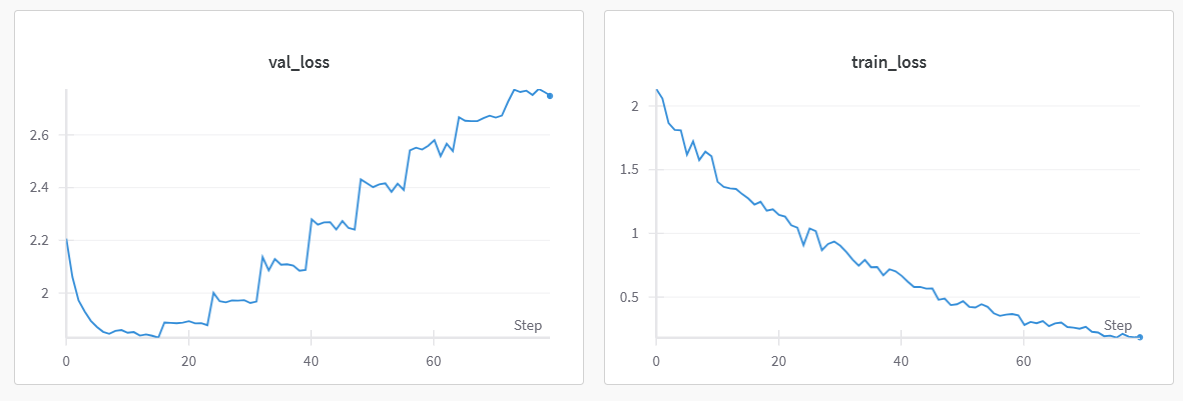

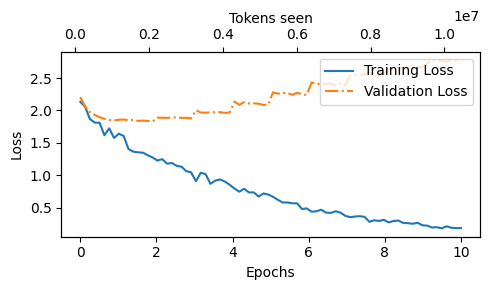

In [22]:
epochs_tensor = torch.linspace(0, train_config.num_epochs, len(train_losses))
plot_losses(epochs_tensor, track_tokens_seen, train_losses, val_losses)